In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

f:\anaconda\envs\YY\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
f:\anaconda\envs\YY\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
f:\anaconda\envs\YY\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
f:\anaconda\envs\YY\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


torch.Size([60000, 28, 28])
torch.Size([60000])


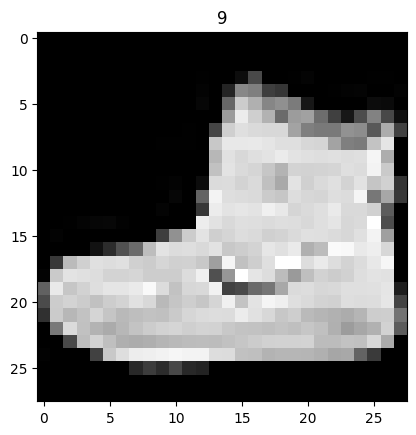

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)
start train
Epoch:  1 | train loss: 2.31 | test accuracy: 0.11
Epoch:  1 | train loss: 1.49 | test accuracy: 0.61
Epoch:  1 | train loss: 0.94 | test accuracy: 0.67
Epoch:  1 | train loss: 0.74 | test accuracy: 0.70
Epoch:  1 | train loss: 0.96 | test accuracy: 0.72
Epoch:  1 | train loss: 0.68 | test accuracy: 0.73
Epoch:  1 | train loss: 0.62 | test accuracy: 0.76
Epoch:  1 | train loss: 0.51 | test accuracy: 0.79
Epoch:  1 | train loss: 0.81 | test accuracy: 0.76
Epoch:  1 | train loss: 0.60 | test accuracy: 0.80
Epoch:  1 | train loss: 0.51 | test accuracy: 0.80
Epoch:  1 | train loss: 1.23 | test accuracy: 0.71
Epoch:  1 | train loss: 0.42 | test accuracy: 0.81
Epoch:  1 | train loss: 0.40 | test accuracy: 0.80
Epoch:  1 | train loss: 0.53 | test accuracy: 0.81
Epoch:  1 | train loss: 0.62 | test accuracy: 0.81
Epoch:  1 | train loss: 0.32 | test accuracy: 0.83
Epoch:  1 | tr

In [2]:
import torch
from torch import nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

from torchvision import datasets, transforms ## 导入数据集与数据预处理的方法
# torch.manual_seed(1)    # reproducible

# Hyper Parameters，定义超参数
EPOCH = 2               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 64        #批训练的数量
TIME_STEP = 28          # rnn time step / image height  考虑28个时间点，一行信息包括28个像素点，
INPUT_SIZE = 28         # rnn input size / image width  每28步中的一步读取一行信息（一行信息包括28个像素点）
LR = 0.01               # learning rate


# FasionMNIST数据集下载
train_data = datasets.FashionMNIST('dataset/', download=True, 
                         train=True,                         # this is training data
                         transform=transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                        # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
                                    # download it if you don't have it
                        )

test_data = datasets.FashionMNIST('dataset/',
                        train=False,                         # 测试集
                        transform=transforms.ToTensor()
                        )

test_x = test_data.test_data.type(torch.FloatTensor)[:2000]/255.   # shape (2000, 28, 28) value in range(0,1)
test_y = test_data.test_labels.numpy()[:2000]    # covert to numpy array，pick 2000 samples to speed up testing

# plot其中一张手写数字图片
print(train_data.train_data.size())     # 查看训练集数据大小，60000张28*28的图片 (60000, 28, 28)
print(train_data.train_labels.size())   # 查看训练集标签大小，60000个标签 (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray') # plot 训练集第一张图片
plt.title('%i' % train_data.train_labels[0])              # 图片名称，显示真实标签，%i %d十进制整数，
plt.show()                                                # show

# Data Loader for easy mini-batch return in training
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
 #构建训练集数据载入器trainloader,每次从训练集中载入64张图片，每次载入都打乱顺序

# 定义网络模型
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(input_size=INPUT_SIZE,  # if use nn.RNN(), it hardly learns
                           hidden_size=64,         # rnn 隐藏单元
                           num_layers=1,           # rnn 层数
                           batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
                          )
        self.out = nn.Linear(64, 10)  #10分类

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

rnn = RNN() # 调用模型
print(rnn)  # 查看模型结构

optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # 选择优化器，optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # 定义损失函数，the target label is not one-hotted

# 训练，测试。training and testing
train_losses, test_losses = [], []
print("start train")
for epoch in range(EPOCH):
    running_loss = 0
    epoch+=1
    for step, (b_x, b_y) in enumerate(train_loader):    # gives batch data
        #print(step)  # 1,2,3,4,5,...,
        #print(b_x)   # 图片向量
        #print(b_y)    # 图片对应的标签
        b_x = b_x.view(-1, 28, 28)                      # reshape x to (batch, time_step, input_size)
        # 前向传播
        output = rnn(b_x)                               # rnn output
        loss = loss_func(output, b_y)                   # cross entropy loss
        running_loss += loss.item()
        # 后向传播
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step() 
                                     # apply gradients

        if step % 50 == 0:
           
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_y).astype(int).sum()) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.2f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)
            
            
        train_losses.append(loss.data.numpy())
            
        test_losses.append(accuracy)






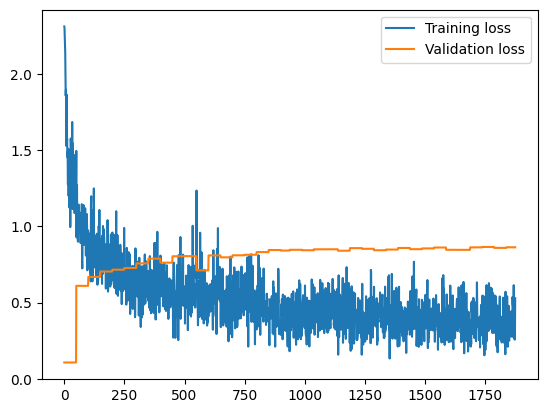

In [3]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend()

[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 6 8 0 2 7 7 5 1 2 6 6 9 6] prediction number
[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3] real number
4 4
神经网络猜测图片里是 外套 


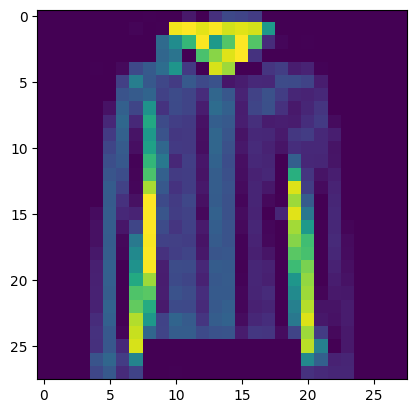

In [18]:
import random
# print 10 predictions from test data
test_output = rnn(test_x[:30].view(-1, 28, 28))
pred_y = torch.max(test_output, 1)[1].data.numpy()
print(pred_y, 'prediction number')
print(test_y[:30], 'real number')
n=random.randint(0,10)
a=pred_y[n]
b=test_y[n]
print(a,b)
img = test_x[n]
img = img.reshape((28,28)).numpy()
plt.imshow(img)
labellist = ['T恤','裤子','套衫','裙子','外套','凉鞋','汗衫','运动鞋','包包','靴子']
prediction = labellist[b]
print(f'神经网络猜测图片里是 {prediction} ')